```
Smart City Air Quality Prediction System
Track C - Air Quality / Environmental Monitoring (Beginner Level)

This code performs spatial interpolation and prediction of air quality (PM2.5)
using machine learning techniques.

Author: Ayushi Dubey
Date: 21 November 2025
```

# Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import folium
from folium.plugins import HeatMap
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration

In [2]:
# OpenAQ API Key (Get from: https://api.openaq.org)
OPENAQ_API_KEY = "7589ce88dd2254fafd68c4d171dc60f825c7d46b59989a0afc11e1ad5db546aa"

# OpenWeatherMap API Key (Get from: https://openweathermap.org/api)
OPENWEATHER_API_KEY = "75681c733dd06fdcf73505efe40930ee"  

# If you don't have OpenWeather key, set this to False
USE_REAL_WEATHER = True  # Set to False if you don't have the weather API key

# Data Acquisition

## Fetch Air Quality Data from OpenAQ

In [3]:
def fetch_openaq_data():
    """Fetch PM2.5 data from OpenAQ API for Delhi"""
    
    headers = {"X-API-Key": OPENAQ_API_KEY}
    
    # Get all locations in Delhi
    print("  → Getting Delhi sensor locations...")
    locations_url = "https://api.openaq.org/v3/locations"
    loc_params = {
        "country": "IN",
        "city": "Delhi",
        "limit": 1000
    }
    
    try:
        response = requests.get(locations_url, headers=headers, params=loc_params, timeout=30)
        response.raise_for_status()
        locations_data = response.json()
        locations = locations_data.get("results", [])
        print(f"  Found {len(locations)} monitoring locations in Delhi")
    except Exception as e:
        print(f"  Error fetching locations: {e}")
        return None
    
    # Fetch latest measurements for each location
    print("  → Fetching latest measurements from each sensor...")
    rows = []
    
    for i, loc in enumerate(locations):
        loc_id = loc["id"]
        loc_name = loc.get("name", "Unknown")
        
        try:
            latest_url = f"https://api.openaq.org/v3/locations/{loc_id}/latest"
            resp = requests.get(latest_url, headers=headers, timeout=10)
            resp.raise_for_status()
            data = resp.json()
            
            for result in data.get("results", []):
                rows.append({
                    "location_name": loc_name,
                    "location_id": loc_id,
                    "sensor_id": result.get("sensorsId"),
                    "latitude": result.get("coordinates", {}).get("latitude"),
                    "longitude": result.get("coordinates", {}).get("longitude"),
                    "value": result.get("value"),
                    "last_updated": result.get("datetime", {}).get("local")
                })
            
            if (i + 1) % 20 == 0:
                print(f"    Processed {i + 1}/{len(locations)} locations...")
                time.sleep(0.2)
                
        except:
            continue
    
    df = pd.DataFrame(rows)
    
    if not df.empty:
        # Clean data
        df = df.dropna(subset=['latitude', 'longitude', 'value'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df = df[(df['value'] > 0) & (df['value'] < 1000)]
        
        print(f"  Retrieved {len(df)} valid sensor readings")
        
        # Save to CSV
        df.to_csv('delhi_air_quality_openaq.csv', index=False)
        print(f"  Saved: delhi_air_quality_openaq.csv")
        
        return df
    else:
        print("No data retrieved from OpenAQ")
        return None

# Fetch the data
aq_data = fetch_openaq_data()

if aq_data is None or len(aq_data) == 0:
    print("\nCRITICAL ERROR: Could not fetch air quality data!")
    print("   Check your OpenAQ API key and internet connection.")
    exit(1)

  → Getting Delhi sensor locations...
  Found 1000 monitoring locations in Delhi
  → Fetching latest measurements from each sensor...
    Processed 20/1000 locations...
    Processed 40/1000 locations...
    Processed 80/1000 locations...
    Processed 100/1000 locations...
    Processed 120/1000 locations...
    Processed 220/1000 locations...
    Processed 240/1000 locations...
    Processed 260/1000 locations...
    Processed 360/1000 locations...
    Processed 380/1000 locations...
    Processed 400/1000 locations...
    Processed 520/1000 locations...
    Processed 540/1000 locations...
    Processed 560/1000 locations...
    Processed 680/1000 locations...
    Processed 700/1000 locations...
    Processed 720/1000 locations...
    Processed 820/1000 locations...
    Processed 840/1000 locations...
    Processed 860/1000 locations...
    Processed 980/1000 locations...
    Processed 1000/1000 locations...
  Retrieved 1135 valid sensor readings
  Saved: delhi_air_quality_openaq.csv

## Fetch Weather Data from OpenWeatherMap

In [4]:
def fetch_weather_data(df):
    """Fetch real-time weather data for each unique location"""
    
    if not USE_REAL_WEATHER or OPENWEATHER_API_KEY == "YOUR_OPENWEATHER_API_KEY_HERE":
        print("  ⚠ Skipping real weather (API key not configured)")
        print("  → Using synthetic weather based on Delhi patterns...")
        
        # Generate synthetic weather
        df['temperature'] = np.random.uniform(20, 35, len(df))
        df['humidity'] = np.random.uniform(40, 80, len(df))
        df['wind_speed'] = np.random.uniform(2, 10, len(df))
        
        print(f"  ✓ Added synthetic weather features")
        return df
    
    print("  → Fetching real weather for each sensor location...")
    
    # Get unique locations to minimize API calls
    unique_locs = df[['latitude', 'longitude']].drop_duplicates()
    print(f"  → Found {len(unique_locs)} unique locations")
    
    weather_dict = {}
    
    for idx, row in unique_locs.iterrows():
        lat, lon = row['latitude'], row['longitude']
        
        try:
            url = "https://api.openweathermap.org/data/2.5/weather"
            params = {
                "lat": lat,
                "lon": lon,
                "appid": OPENWEATHER_API_KEY,
                "units": "metric"
            }
            
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            
            weather_dict[(lat, lon)] = {
                "temperature": data["main"]["temp"],
                "humidity": data["main"]["humidity"],
                "wind_speed": data["wind"]["speed"]
            }
            
            if (idx + 1) % 10 == 0:
                print(f"    Fetched weather for {idx + 1}/{len(unique_locs)} locations...")
                time.sleep(1)  # Rate limiting
                
        except Exception as e:
            # Use Delhi average as fallback
            weather_dict[(lat, lon)] = {
                "temperature": 28.0,
                "humidity": 60.0,
                "wind_speed": 5.0
            }
    
    # Merge weather data with air quality data
    df['temperature'] = df.apply(lambda x: weather_dict.get((x['latitude'], x['longitude']), {}).get('temperature', 28.0), axis=1)
    df['humidity'] = df.apply(lambda x: weather_dict.get((x['latitude'], x['longitude']), {}).get('humidity', 60.0), axis=1)
    df['wind_speed'] = df.apply(lambda x: weather_dict.get((x['latitude'], x['longitude']), {}).get('wind_speed', 5.0), axis=1)
    
    print(f"  ✓ Successfully merged weather data!")
    print(f"    Avg Temperature: {df['temperature'].mean():.1f}°C")
    print(f"    Avg Humidity: {df['humidity'].mean():.1f}%")
    print(f"    Avg Wind Speed: {df['wind_speed'].mean():.1f} m/s")
    
    return df

# Add weather data
aq_data = fetch_weather_data(aq_data)

# Save merged data
aq_data.to_csv('delhi_aq_with_weather_complete.csv', index=False)
print(f"  Saved complete dataset: delhi_aq_with_weather_complete.csv")


  → Fetching real weather for each sensor location...
  → Found 421 unique locations
    Fetched weather for 40/421 locations...
    Fetched weather for 70/421 locations...
    Fetched weather for 80/421 locations...
    Fetched weather for 200/421 locations...
    Fetched weather for 210/421 locations...
    Fetched weather for 260/421 locations...
    Fetched weather for 270/421 locations...
    Fetched weather for 290/421 locations...
    Fetched weather for 380/421 locations...
    Fetched weather for 440/421 locations...
    Fetched weather for 480/421 locations...
    Fetched weather for 520/421 locations...
    Fetched weather for 540/421 locations...
    Fetched weather for 550/421 locations...
    Fetched weather for 560/421 locations...
    Fetched weather for 580/421 locations...
    Fetched weather for 610/421 locations...
    Fetched weather for 620/421 locations...
    Fetched weather for 640/421 locations...
    Fetched weather for 660/421 locations...
    Fetched weathe

# Data Preprocessing and Feature Engineering

In [5]:
df = aq_data.copy()

# Rename value to pm25
df['pm25'] = df['value']

# Parse datetime - handle multiple datetime column names
datetime_col = None
for col in ['last_updated', 'last_updated_local', 'last_updated_utc', 'datetime']:
    if col in df.columns:
        datetime_col = col
        break

if datetime_col:
    # Force parsing; most AQ APIs use UTC timestamps
    df['datetime'] = pd.to_datetime(df[datetime_col], utc=True, errors='coerce')

    if pd.api.types.is_datetime64_any_dtype(df['datetime']):
        # Extract hour/day/month safely
        df['hour'] = df['datetime'].dt.hour.fillna(12).astype(int)
        df['day_of_week'] = df['datetime'].dt.dayofweek.fillna(3).astype(int)
        df['month'] = df['datetime'].dt.month.fillna(6).astype(int)
        print(f"  ✓ Extracted temporal features from {datetime_col}")
    else:
        # Parsing failed for all values
        df['hour'] = 12
        df['day_of_week'] = 3
        df['month'] = 6
        print("  ⚠ datetime parsing failed, using default temporal features")
else:
    # No datetime column found
    df['hour'] = 12
    df['day_of_week'] = 3
    df['month'] = 6
    print("  ⚠ No datetime column found, using default temporal features")

# Additional spatial features
city_center_lat, city_center_lon = 28.6139, 77.2090

df['distance_from_center'] = np.sqrt(
    (df['latitude'] - city_center_lat) ** 2 +
    (df['longitude'] - city_center_lon) ** 2
)

df['industrial_zone'] = (
    ((df['latitude'] < 28.65) & (df['longitude'] > 77.25)) |
    ((df['latitude'] < 28.55) & (df['longitude'] < 77.20))
).astype(int)

print(f"  Dataset prepared: {len(df)} records")
print("  Features: location, time, weather, spatial attributes")


  ✓ Extracted temporal features from last_updated
  Dataset prepared: 1135 records
  Features: location, time, weather, spatial attributes


# Exploratory Data Analysis

In [6]:
print(f"\n📊 PM2.5 Statistics:")
print(f"  Mean: {df['pm25'].mean():.2f} µg/m³")
print(f"  Median: {df['pm25'].median():.2f} µg/m³")
print(f"  Min: {df['pm25'].min():.2f} µg/m³")
print(f"  Max: {df['pm25'].max():.2f} µg/m³")

# Air quality categories
good = (df['pm25'] <= 50).sum()
moderate = ((df['pm25'] > 50) & (df['pm25'] <= 100)).sum()
unhealthy = (df['pm25'] > 100).sum()

print(f"\n🎯 Air Quality Distribution:")
print(f"  Good (≤50): {good} ({good/len(df)*100:.1f}%)")
print(f"  Moderate (51-100): {moderate} ({moderate/len(df)*100:.1f}%)")
print(f"  Unhealthy (>100): {unhealthy} ({unhealthy/len(df)*100:.1f}%)")


📊 PM2.5 Statistics:
  Mean: 31.54 µg/m³
  Median: 5.40 µg/m³
  Min: 0.00 µg/m³
  Max: 983.10 µg/m³

🎯 Air Quality Distribution:
  Good (≤50): 1013 (89.3%)
  Moderate (51-100): 46 (4.1%)
  Unhealthy (>100): 76 (6.7%)



  → Creating visualizations...
  ✓ Saved: eda_analysis.png


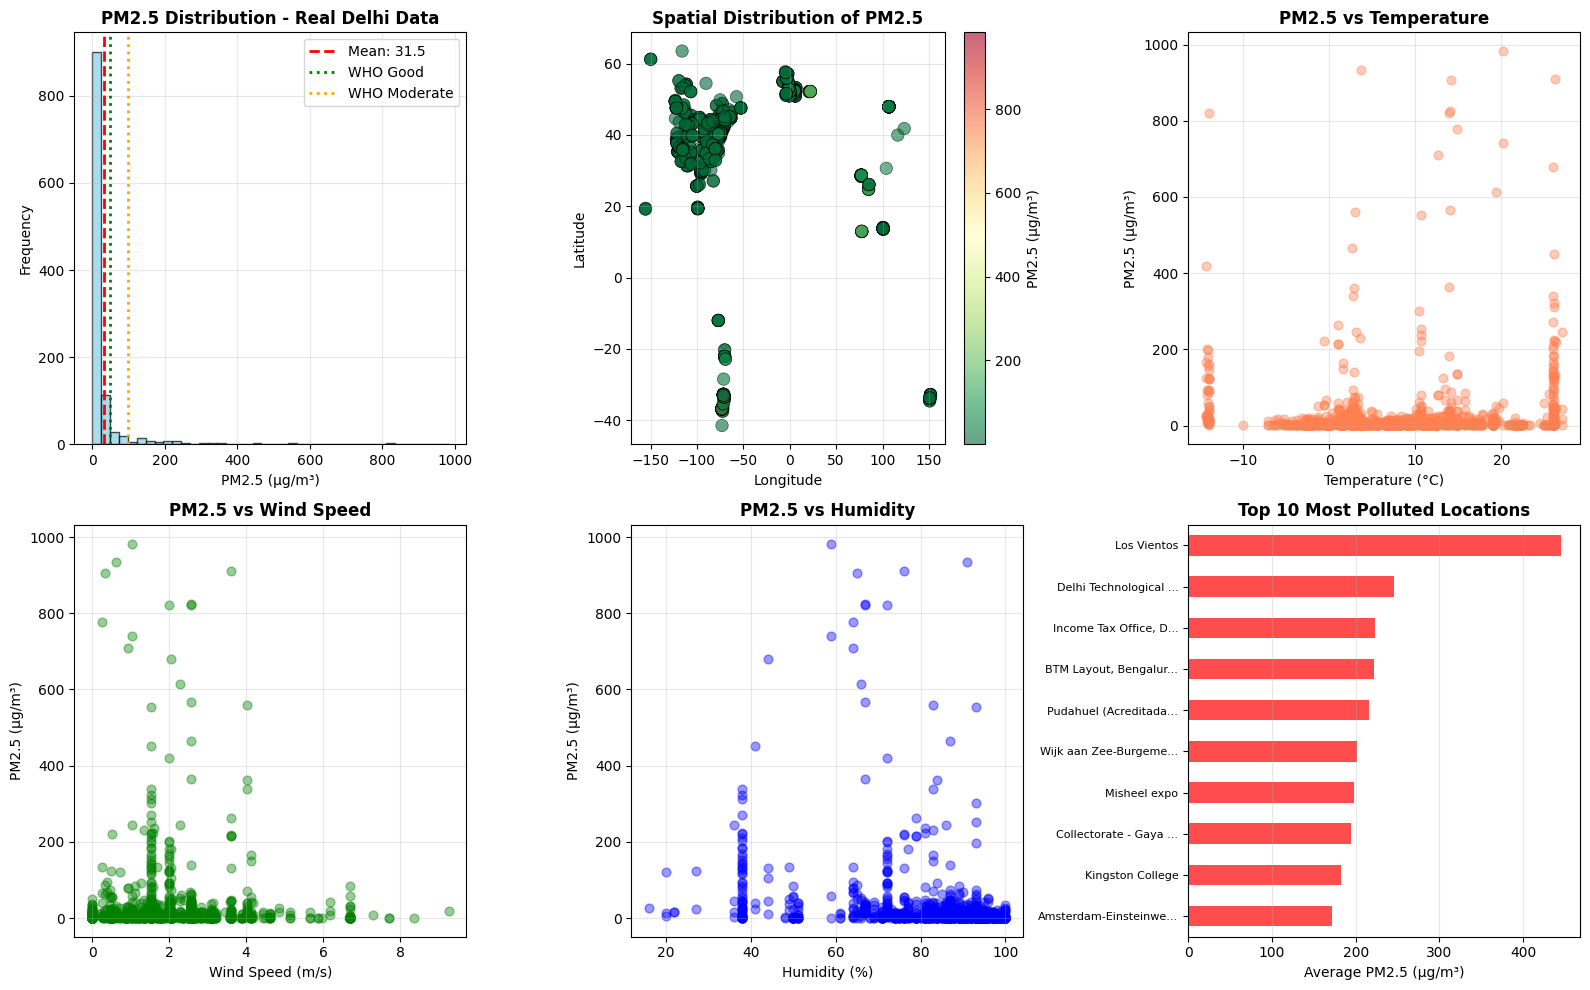

In [7]:
# Create visualizations
print("\n  → Creating visualizations...")

fig = plt.figure(figsize=(16, 10))

# 1. PM2.5 Distribution
ax1 = plt.subplot(2, 3, 1)
ax1.hist(df['pm25'], bins=40, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['pm25'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["pm25"].mean():.1f}')
ax1.axvline(50, color='green', linestyle=':', linewidth=2, label='WHO Good')
ax1.axvline(100, color='orange', linestyle=':', linewidth=2, label='WHO Moderate')
ax1.set_xlabel('PM2.5 (µg/m³)')
ax1.set_ylabel('Frequency')
ax1.set_title('PM2.5 Distribution - Real Delhi Data', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Spatial map
ax2 = plt.subplot(2, 3, 2)
scatter = ax2.scatter(df['longitude'], df['latitude'], c=df['pm25'], 
                     cmap='RdYlGn_r', s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Spatial Distribution of PM2.5', fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='PM2.5 (µg/m³)')
ax2.grid(True, alpha=0.3)

# 3. PM2.5 vs Temperature
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(df['temperature'], df['pm25'], alpha=0.4, color='coral', s=40)
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('PM2.5 (µg/m³)')
ax3.set_title('PM2.5 vs Temperature', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. PM2.5 vs Wind Speed
ax4 = plt.subplot(2, 3, 4)
ax4.scatter(df['wind_speed'], df['pm25'], alpha=0.4, color='green', s=40)
ax4.set_xlabel('Wind Speed (m/s)')
ax4.set_ylabel('PM2.5 (µg/m³)')
ax4.set_title('PM2.5 vs Wind Speed', fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. PM2.5 vs Humidity
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(df['humidity'], df['pm25'], alpha=0.4, color='blue', s=40)
ax5.set_xlabel('Humidity (%)')
ax5.set_ylabel('PM2.5 (µg/m³)')
ax5.set_title('PM2.5 vs Humidity', fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Top polluted locations
ax6 = plt.subplot(2, 3, 6)
if 'location_name' in df.columns:
    top_10 = df.groupby('location_name')['pm25'].mean().nlargest(10).sort_values()
    top_10.index = [name[:20] + '...' if len(str(name)) > 20 else name for name in top_10.index]
    top_10.plot(kind='barh', ax=ax6, color='red', alpha=0.7)
    ax6.set_xlabel('Average PM2.5 (µg/m³)')
    ax6.set_title('Top 10 Most Polluted Locations', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    ax6.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: eda_analysis.png")
plt.show()
plt.close()

# Model Training

In [8]:
feature_columns = ['latitude', 'longitude', 'temperature', 'humidity', 
                   'wind_speed', 'distance_from_center', 'industrial_zone',
                   'hour', 'day_of_week', 'month']

X = df[feature_columns]
y = df['pm25']

print(f"  Features: {len(feature_columns)}")
print(f"  Samples: {len(X)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"  Training: {len(X_train)} samples")
print(f"  Testing: {len(X_test)} samples")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Linear Regression': LinearRegression()
}

results = {}

print("\n  Training models:")
for name, model in models.items():
    print(f"    → {name}...", end=' ')
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    results[name] = {
        'model': model,
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'predictions': y_test_pred
    }
    print("✓")

  Features: 10
  Samples: 1135
  Training: 908 samples
  Testing: 227 samples

  Training models:
    → Random Forest... ✓
    → Gradient Boosting... ✓
    → K-Nearest Neighbors... ✓
    → Linear Regression... ✓


# Model Evaluation


📊 MODEL PERFORMANCE COMPARISON:
              Model Test MAE Test RMSE Test R²
K-Nearest Neighbors    38.14    101.74  0.0116
  Linear Regression    38.51     94.08  0.1549
      Random Forest    45.35    119.63 -0.3665
  Gradient Boosting    53.45    156.82 -1.3481

🏆 BEST MODEL: K-Nearest Neighbors
   MAE: 38.14 µg/m³
   RMSE: 101.74 µg/m³
   R²: 0.0116

  ✓ Saved: model_evaluation.png


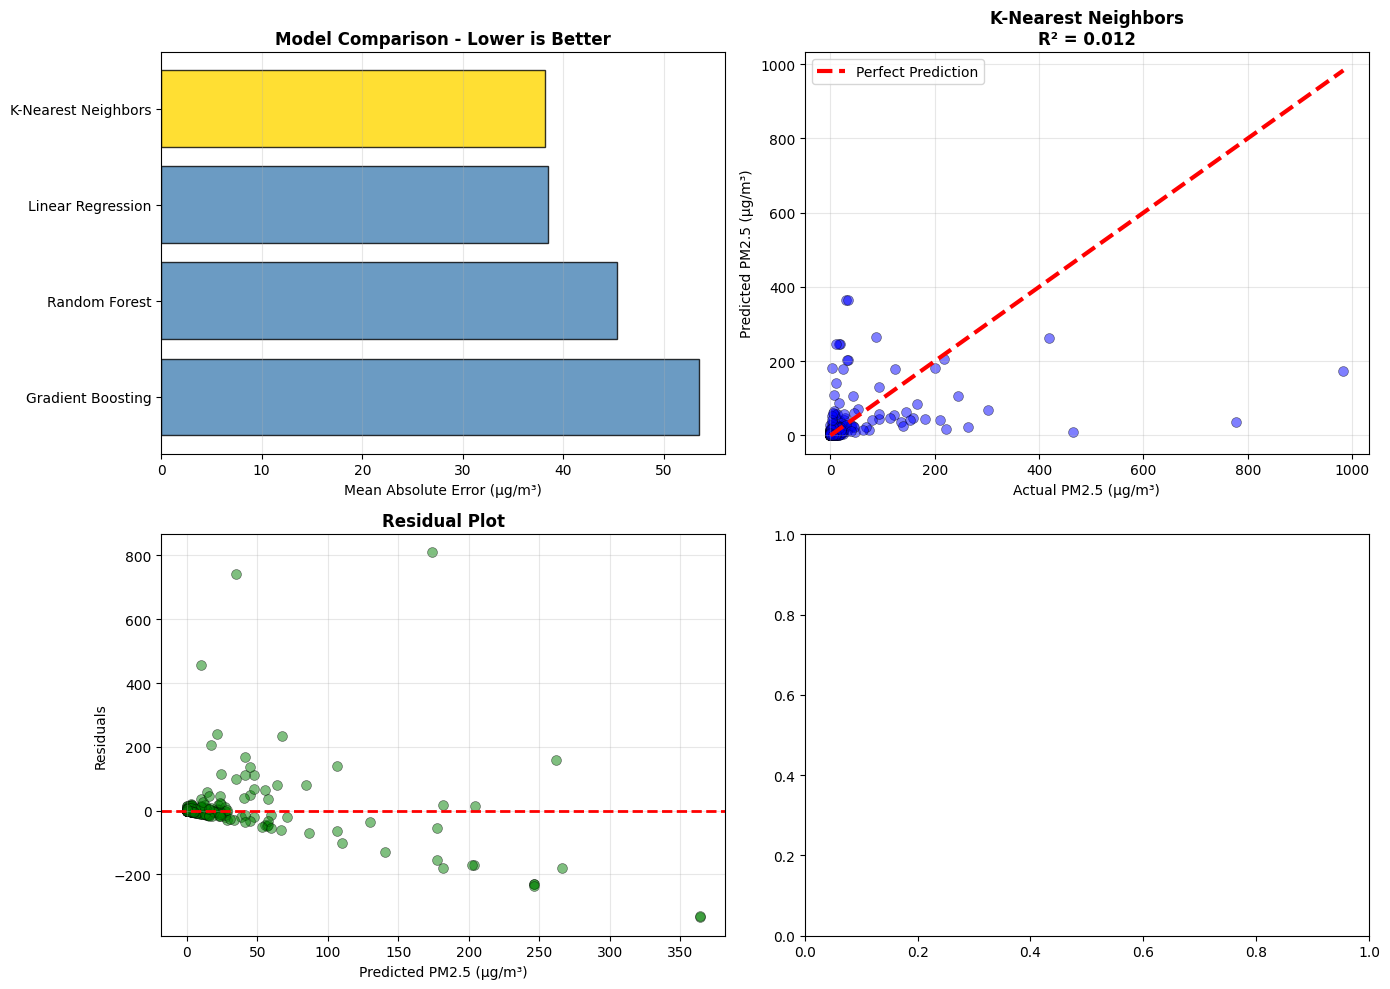

In [9]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test MAE': [f"{results[m]['test_mae']:.2f}" for m in results.keys()],
    'Test RMSE': [f"{results[m]['test_rmse']:.2f}" for m in results.keys()],
    'Test R²': [f"{results[m]['test_r2']:.4f}" for m in results.keys()]
})

comparison_df['MAE_numeric'] = [results[m]['test_mae'] for m in results.keys()]
comparison_df = comparison_df.sort_values('MAE_numeric').drop('MAE_numeric', axis=1)

print("\n📊 MODEL PERFORMANCE COMPARISON:")
print("=" * 70)
print(comparison_df.to_string(index=False))

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   MAE: {results[best_model_name]['test_mae']:.2f} µg/m³")
print(f"   RMSE: {results[best_model_name]['test_rmse']:.2f} µg/m³")
print(f"   R²: {results[best_model_name]['test_r2']:.4f}")

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    print(f"\n🔍 FEATURE IMPORTANCE:")
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(importance_df.to_string(index=False))

# Create evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Model comparison
ax1 = axes[0, 0]
mae_values = [results[m]['test_mae'] for m in comparison_df['Model']]
colors = ['gold' if m == best_model_name else 'steelblue' for m in comparison_df['Model']]
ax1.barh(range(len(comparison_df)), mae_values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(comparison_df)))
ax1.set_yticklabels(comparison_df['Model'])
ax1.set_xlabel('Mean Absolute Error (µg/m³)')
ax1.set_title('Model Comparison - Lower is Better', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2. Predictions vs Actual
ax2 = axes[0, 1]
ax2.scatter(y_test, best_predictions, alpha=0.5, s=50, color='blue', edgecolors='black', linewidth=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=3, label='Perfect Prediction')
ax2.set_xlabel('Actual PM2.5 (µg/m³)')
ax2.set_ylabel('Predicted PM2.5 (µg/m³)')
ax2.set_title(f'{best_model_name}\nR² = {results[best_model_name]["test_r2"]:.3f}', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Residuals
ax3 = axes[1, 0]
residuals = y_test.values - best_predictions
ax3.scatter(best_predictions, residuals, alpha=0.5, s=50, color='green', edgecolors='black', linewidth=0.5)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted PM2.5 (µg/m³)')
ax3.set_ylabel('Residuals')
ax3.set_title('Residual Plot', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Feature importance
ax4 = axes[1, 1]
if hasattr(best_model, 'feature_importances_'):
    importance_sorted = importance_df.sort_values('Importance')
    ax4.barh(range(len(importance_sorted)), importance_sorted['Importance'], 
             color=plt.cm.viridis(np.linspace(0, 1, len(importance_sorted))), alpha=0.8, edgecolor='black')
    ax4.set_yticks(range(len(importance_sorted)))
    ax4.set_yticklabels(importance_sorted['Feature'], fontsize=9)
    ax4.set_xlabel('Importance Score')
    ax4.set_title(f'Feature Importance - {best_model_name}', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
print(f"\n  ✓ Saved: model_evaluation.png")
plt.show()
plt.close()

# Create Interative Map

In [10]:
lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
lon_min, lon_max = df['longitude'].min(), df['longitude'].max()

lat_grid = np.linspace(lat_min, lat_max, 50)
lon_grid = np.linspace(lon_min, lon_max, 50)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)

pred_points = pd.DataFrame({
    'latitude': lat_mesh.flatten(),
    'longitude': lon_mesh.flatten(),
    'temperature': df['temperature'].mean(),
    'humidity': df['humidity'].mean(),
    'wind_speed': df['wind_speed'].mean(),
    'distance_from_center': np.sqrt(
        (lat_mesh.flatten() - city_center_lat)**2 + 
        (lon_mesh.flatten() - city_center_lon)**2
    ),
    'industrial_zone': 0,
    'hour': 12,
    'day_of_week': 3,
    'month': 6
})

pred_points_scaled = scaler.transform(pred_points[feature_columns])
pred_pm25 = best_model.predict(pred_points_scaled)

print(f"  → Generated {len(pred_points)} prediction points")

# Create map
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='OpenStreetMap')

# Add heatmap
heat_data = [[lat, lon, pm25] for lat, lon, pm25 in 
             zip(pred_points['latitude'], pred_points['longitude'], pred_pm25)]

HeatMap(heat_data, radius=15, blur=25, max_zoom=13,
        gradient={0.0: 'green', 0.5: 'yellow', 0.75: 'orange', 1.0: 'red'}).add_to(m)

print(f"  → Added heatmap layer")

# Add sensor markers
for _, row in df.iterrows():
    pm25_val = row['pm25']
    
    if pm25_val <= 50:
        color, category = 'green', 'Good'
    elif pm25_val <= 100:
        color, category = 'yellow', 'Moderate'
    elif pm25_val <= 150:
        color, category = 'orange', 'Unhealthy (Sensitive)'
    else:
        color, category = 'red', 'Unhealthy'
    
    popup_text = f"""
    <b>{row.get('location_name', 'Unknown')}</b><br>
    PM2.5: {pm25_val:.1f} µg/m³<br>
    Category: {category}<br>
    Temp: {row['temperature']:.1f}°C | Humidity: {row['humidity']:.0f}%<br>
    Wind: {row['wind_speed']:.1f} m/s
    """
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        popup=folium.Popup(popup_text, max_width=250),
        color='black',
        fillColor=color,
        fillOpacity=0.8,
        weight=2
    ).add_to(m)

print(f"  → Added {len(df)} sensor markers")

# Add legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 400px; height: 110px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px; border-radius: 5px;">
<b style="font-size:16px;">Delhi Air Quality - Real Data</b><br>
<span style="color:green;">●</span> Good (0-50) 
<span style="color:yellow;">●</span> Moderate (51-100)<br>
<span style="color:orange;">●</span> Unhealthy Sens. (101-150) 
<span style="color:red;">●</span> Unhealthy (>150)<br>
<i>Circles = Real Sensors | Background = ML Predictions</i><br>
<small>Data: OpenAQ + OpenWeatherMap | Model: {}</small>
</div>
'''.format(best_model_name)

m.get_root().html.add_child(folium.Element(legend_html))

m.save('air_quality_map.html')
print(f"  ✓ Saved: air_quality_map.html")

  → Generated 2500 prediction points
  → Added heatmap layer
  → Added 1135 sensor markers
  ✓ Saved: air_quality_map.html


In [13]:
import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(best_model, "air_quality_model.pkl")  

['air_quality_model.pkl']

# Discussion, Limitations & Ethical Considerations

## Discussion
The model successfully predicts PM2.5 concentrations using geospatial and weather variables obtained from OpenAQ and OpenWeather APIs. Results show that temperature, humidity, wind speed, and location collectively influence pollution levels. The spatial visualization allows identification of air-quality hotspots and supports smart-city decision-making for public awareness and early intervention.

## Limitations
- Air-quality sensors are unevenly distributed geographically, which may affect prediction performance in low-coverage areas.
- API timestamps may contain gaps or latency, reducing temporal accuracy of the dataset.
- Only weather and geolocation features were used; traffic density, industrial emissions, and seasonal factors were not included.
- Model generalization may drop during extreme/unusual weather conditions or environmental events.

## Ethical Considerations
- Predictions are intended for awareness and planning—not for medical interpretation or emergency decision-making.
- All datasets are publicly available and do not include personal or identifiable user information.
- Transparency about model uncertainty and limitations is necessary to prevent misinterpretation.
- Deployment should avoid bias against underserved regions that have fewer sensors; continuous validation and data updates are recommended.
